<a href="https://colab.research.google.com/github/itinasharma/MachineLearning/blob/main/confidence_divergence_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

MODEL COMPARISON
----------------
Model A | Accuracy: 0.900, Loss: 0.378, Brier: 0.110
Model B | Accuracy: 0.912, Loss: 0.245, Brier: 0.073


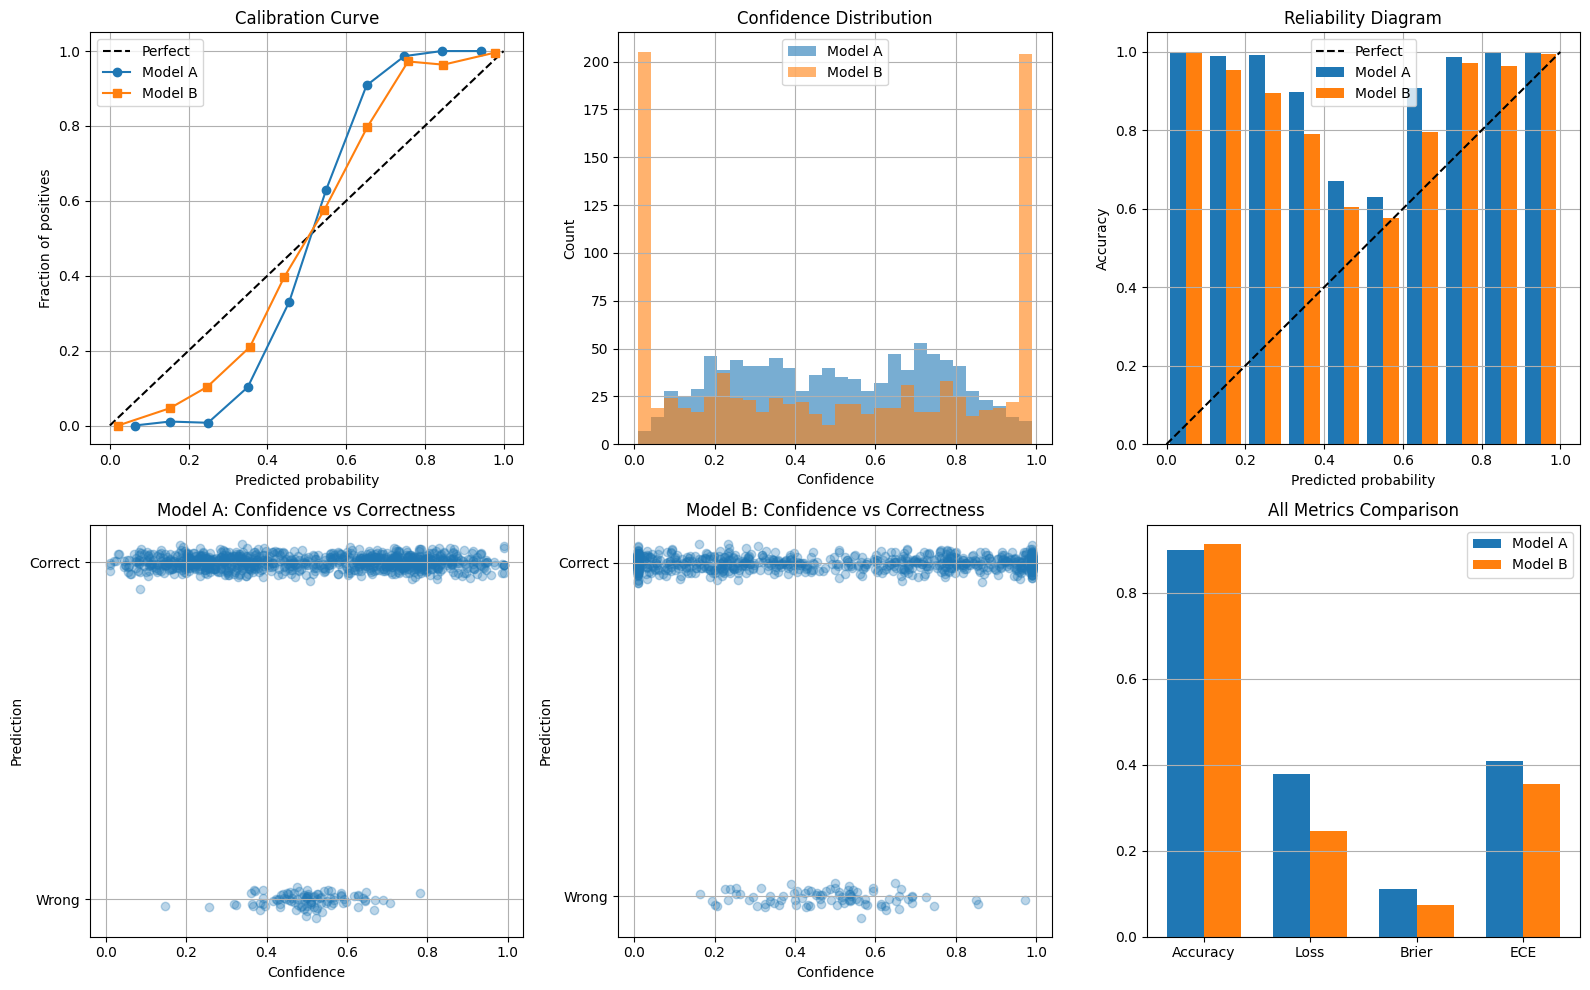

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from sklearn.calibration import calibration_curve
from sklearn.metrics import log_loss, accuracy_score, brier_score_loss

# --------------------------------------------------
# Setup
# --------------------------------------------------

np.random.seed(42)

n_samples = 1000
true_labels = np.random.binomial(1, 0.5, n_samples)


# --------------------------------------------------
# Model A: well calibrated
# --------------------------------------------------

def generate_model_a_predictions(true_labels):
    predictions = []
    confidences = []

    for label in true_labels:
        if label == 1:
            prob = np.random.beta(7, 3)
        else:
            prob = np.random.beta(3, 7)

        prob = np.clip(prob + np.random.normal(0, 0.05), 0.01, 0.99)

        confidences.append(prob)
        predictions.append(1 if prob > 0.5 else 0)

    return np.array(predictions), np.array(confidences)


# --------------------------------------------------
# Model B: overconfident
# --------------------------------------------------

def generate_model_b_predictions(true_labels):
    predictions = []
    confidences = []

    for label in true_labels:
        if label == 1:
            prob = np.random.beta(7, 3)
        else:
            prob = np.random.beta(3, 7)

        if prob > 0.5:
            prob = 0.5 + (prob - 0.5) * 1.8
        else:
            prob = 0.5 - (0.5 - prob) * 1.8

        prob = np.clip(prob, 0.01, 0.99)

        confidences.append(prob)
        predictions.append(1 if prob > 0.5 else 0)

    return np.array(predictions), np.array(confidences)


# --------------------------------------------------
# Generate predictions
# --------------------------------------------------

pred_a, conf_a = generate_model_a_predictions(true_labels)
pred_b, conf_b = generate_model_b_predictions(true_labels)


# --------------------------------------------------
# Metrics
# --------------------------------------------------

acc_a = accuracy_score(true_labels, pred_a)
acc_b = accuracy_score(true_labels, pred_b)

loss_a = log_loss(true_labels, conf_a)
loss_b = log_loss(true_labels, conf_b)

brier_a = brier_score_loss(true_labels, conf_a)
brier_b = brier_score_loss(true_labels, conf_b)

print("MODEL COMPARISON")
print("----------------")
print(f"Model A | Accuracy: {acc_a:.3f}, Loss: {loss_a:.3f}, Brier: {brier_a:.3f}")
print(f"Model B | Accuracy: {acc_b:.3f}, Loss: {loss_b:.3f}, Brier: {brier_b:.3f}")


# --------------------------------------------------
# Plots
# --------------------------------------------------

fig = plt.figure(figsize=(16, 10))

# 1. Calibration curve
ax1 = plt.subplot(2, 3, 1)

frac_a, mean_a = calibration_curve(true_labels, conf_a, n_bins=10)
frac_b, mean_b = calibration_curve(true_labels, conf_b, n_bins=10)

plt.plot([0, 1], [0, 1], "k--", label="Perfect")
plt.plot(mean_a, frac_a, "o-", label="Model A")
plt.plot(mean_b, frac_b, "s-", label="Model B")

plt.xlabel("Predicted probability")
plt.ylabel("Fraction of positives")
plt.title("Calibration Curve")
plt.legend()
plt.grid(True)


# 2. Confidence distribution
ax2 = plt.subplot(2, 3, 2)

plt.hist(conf_a, bins=30, alpha=0.6, label="Model A")
plt.hist(conf_b, bins=30, alpha=0.6, label="Model B")

plt.xlabel("Confidence")
plt.ylabel("Count")
plt.title("Confidence Distribution")
plt.legend()
plt.grid(True)


# 3. Reliability diagram
ax3 = plt.subplot(2, 3, 3)

bins = np.linspace(0, 1, 11)
bin_centers = (bins[:-1] + bins[1:]) / 2

acc_bins_a = []
acc_bins_b = []

for i in range(len(bins) - 1):
    mask_a = (conf_a >= bins[i]) & (conf_a < bins[i + 1])
    mask_b = (conf_b >= bins[i]) & (conf_b < bins[i + 1])

    acc_bins_a.append(
        (pred_a[mask_a] == true_labels[mask_a]).mean()
        if mask_a.sum() > 0 else 0
    )

    acc_bins_b.append(
        (pred_b[mask_b] == true_labels[mask_b]).mean()
        if mask_b.sum() > 0 else 0
    )

width = 0.04

plt.bar(bin_centers - width / 2, acc_bins_a, width, label="Model A")
plt.bar(bin_centers + width / 2, acc_bins_b, width, label="Model B")
plt.plot([0, 1], [0, 1], "k--", label="Perfect")

plt.xlabel("Predicted probability")
plt.ylabel("Accuracy")
plt.title("Reliability Diagram")
plt.legend()
plt.grid(True)


# 4. Model A: confidence vs correctness
ax4 = plt.subplot(2, 3, 4)

correct_a = pred_a == true_labels
jitter_a = np.random.normal(0, 0.02, len(conf_a))

plt.scatter(conf_a, correct_a + jitter_a, alpha=0.3)
plt.yticks([0, 1], ["Wrong", "Correct"])
plt.xlabel("Confidence")
plt.ylabel("Prediction")
plt.title("Model A: Confidence vs Correctness")
plt.grid(True)


# 5. Model B: confidence vs correctness
ax5 = plt.subplot(2, 3, 5)

correct_b = pred_b == true_labels
jitter_b = np.random.normal(0, 0.02, len(conf_b))

plt.scatter(conf_b, correct_b + jitter_b, alpha=0.3)
plt.yticks([0, 1], ["Wrong", "Correct"])
plt.xlabel("Confidence")
plt.ylabel("Prediction")
plt.title("Model B: Confidence vs Correctness")
plt.grid(True)


# 6. All metrics comparison
ax6 = plt.subplot(2, 3, 6)

ece_a = np.abs(np.array(acc_bins_a) - bin_centers).mean()
ece_b = np.abs(np.array(acc_bins_b) - bin_centers).mean()

metrics = ["Accuracy", "Loss", "Brier", "ECE"]
vals_a = [acc_a, loss_a, brier_a, ece_a]
vals_b = [acc_b, loss_b, brier_b, ece_b]

x = np.arange(len(metrics))
width = 0.35

plt.bar(x - width / 2, vals_a, width, label="Model A")
plt.bar(x + width / 2, vals_b, width, label="Model B")

plt.xticks(x, metrics)
plt.title("All Metrics Comparison")
plt.legend()
plt.grid(True, axis="y")


plt.tight_layout()
plt.savefig("calibration_analysis.png", dpi=300)
plt.show()
